In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader

# Импортируем модули, связанные с компьютерным зрением
from torchvision import datasets
from torchvision.transforms import ToTensor

# Импортируем вспомогательные модули
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# В этой части предлагается реализовать сверточную сеть.
# Поэкспериментируйте с использованием слоев пакетной нормализации и дропаута.
# Сравните точность на тестовой выборке с аналогичными результатами одногруппников.
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # ВАШ КОД ЗДЕСЬ
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(in_features=64*4*4, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        # ===============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = func.relu(self.conv1(x))
        x = func.max_pool2d(x, 2, 2)
        
        x = func.relu(self.conv2(x))
        x = func.max_pool2d(x, 2, 2)
        
        x = func.relu(self.conv3(x))
        x = func.max_pool2d(x, 2, 2)

        x = func.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(func.dropout(x))
        
        # ===========
        return x


In [3]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 25
BATCH_SIZE = 256

# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=ToTensor())

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(device)

cuda


In [5]:
# Готовимся к обучению
model = ConvNet().to(device)  # создаем модель
optimizer = torch.optim.AdamW(model.parameters())  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости


In [7]:
# Начинаем обучение
for epoch in range(EPOCHS):
    for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
        # Нужно реализовать один шаг градиентного спуска
        loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
        # ВАШ КОД ЗДЕСЬ
        optimizer.zero_grad()
        output = model(batch.cuda())
        loss = loss_function(output.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
        # ===============
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')


Эпоха 1 завершилась с функцией стоимости на последнем пакете = 1.6253938674926758
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 1.2569833993911743
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 1.287004828453064
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 1.1659328937530518
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 1.4122366905212402
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 0.901894748210907
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 1.1461331844329834
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 1.0067405700683594
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 1.0413826704025269
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 0.8235341310501099
Эпоха 11 завершилась с функцией стоимости на последнем пакете = 0.8410789370536804
Эпоха 12 завершилась с функцией стоимости на последнем пакете = 0.8637111783027649
Эпоха 13 заверш

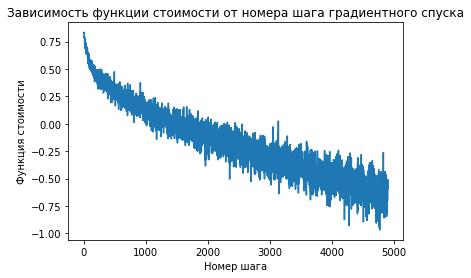

In [18]:
# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [19]:
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
    # Оцениваем качество модели
    train_data_loader = DataLoader(train_data, batch_size=len(train_data))
    train_features, train_targets = next(iter(train_data_loader))

    train_features = train_features.to(device)
    train_model_predictions = torch.argmax(model(train_features), dim=1)
    print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions))

    test_data_loader = DataLoader(test_data, batch_size=len(test_data))
    test_features, test_targets = next(iter(test_data_loader))

    test_features = test_features.to(device)
    test_model_predictions = torch.argmax(model(test_features), dim=1)
    print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions))


Точность (accuracy) на обучающей выборке: 0.82242
Точность (accuracy) на тестовой выборке: 0.7014


# Sequential

In [8]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # ВАШ КОД ЗДЕСЬ
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            )

        # ===============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        return self.network(x)
        # ===============

In [9]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 15
BATCH_SIZE = 256

# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=ToTensor())

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


In [10]:
print(device)

cuda


In [11]:
# Готовимся к обучению
model = ConvNet().to(device)  # создаем модель
optimizer = torch.optim.AdamW(model.parameters())  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости

In [13]:
# Начинаем обучение
for epoch in range(EPOCHS):
    for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
        # Нужно реализовать один шаг градиентного спуска
        loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
        optimizer.zero_grad()
        # ВАШ КОД ЗДЕСЬ
        output = model(batch.cuda())
        loss = loss_function(output.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
        # ===============
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')

Эпоха 1 завершилась с функцией стоимости на последнем пакете = 1.527031660079956
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 1.2769553661346436
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 1.1519381999969482
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 1.101296067237854
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 0.6308630704879761
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 0.6147817969322205
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 0.49812427163124084
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 0.489685595035553
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 0.20051893591880798
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 0.17229965329170227
Эпоха 11 завершилась с функцией стоимости на последнем пакете = 0.17327003180980682
Эпоха 12 завершилась с функцией стоимости на последнем пакете = 0.11188532412052155
Эпоха 13 за

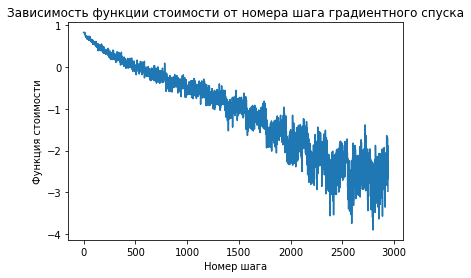

In [14]:
# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [78]:
torch.cuda.empty_cache()
import gc
gc.collect()

57

In [74]:
BATCH_DELIMETER = 16

In [79]:
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
    # Оцениваем качество модели
    train_data_loader = DataLoader(train_data, batch_size=len(train_data) // BATCH_DELIMETER)
    train_data_iterator = iter(train_data_loader)
    train_features, train_targets = next(train_data_iterator)
    train_features = train_features.to(device)
    train_model_predictions = torch.argmax(model(train_features), dim=1)
    for i in range(BATCH_DELIMETER - 1):
        train_features, train_targets = next(train_data_iterator)
        train_features = train_features.to(device)

        train_model_predictions = torch.cat((train_model_predictions, torch.argmax(model(train_features), dim=1)), 0)
    
    print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions.cpu()))

    torch.cuda.empty_cache()

    test_data_loader = DataLoader(test_data, batch_size=len(test_data) // BATCH_DELIMETER)
    test_data_iterator = iter(test_data_loader)
    test_features, test_targets = next(test_data_iterator)
    test_features = test_features.to(device)
    test_model_predictions = torch.argmax(model(test_features), dim=1)

    for i in range(BATCH_DELIMETER - 1):
        test_features, test_targets = next(test_data_iterator)
        test_features = test_features.to(device)

        test_model_predictions = torch.cat((test_model_predictions, torch.argmax(model(test_features), dim=1)), 0)

    print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions.cpu()))

Точность (accuracy) на обучающей выборке: 0.96822
Точность (accuracy) на тестовой выборке: 0.7704
